In [1]:
import sys
sys.path.append("./../..")

In [107]:
from collections import namedtuple
%matplotlib inline
import numpy as np
from numpy.lib.recfunctions import append_fields
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.utils import as_float_array
from yellowbrick.cluster.base import ClusteringScoreVisualizer
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.style import resolve_colors, color_palette

In [232]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { height:100% !important; }</style>"))

ERROR:root:Line magic function `%javascript` not found (But cell magic `%%javascript` exists, did you mean that instead?).


AttributeError: module 'IPython' has no attribute 'OutputArea'

In [108]:
%reload_ext yellowbrick
# from yellowbrick.cluster.iterlabels import *
from yellowbrick.cluster.base import ClusteringScoreVisualizer
from yellowbrick.features import ScatterVisualizer

In [234]:
class IterPlotVisualizer(ClusteringScoreVisualizer):
    """
    TODO: Document this class!
    """

    def __init__(self, model, ax=None, group_label=None, **kwargs):
        super(IterLabelsVisualizer, self).__init__(model, ax=ax, **kwargs)

        # Visual Properties
        # TODO: Fix the color handling
        self.colormap = kwargs.get('colormap', 'set1')
        self.color = kwargs.get('color', None)
        self.group_label_ = group_label if group_label else 'group_label'

        # Required internal properties
        self.X = None
        self.y = None
        self.time_slices = None
        self.labels_ = None
        
    def get_label_slices(self):
        """Groupby for Label Analysis"""
        # Grap the label class  column and sort it
        label_array = self.y

        # Determine the what label class ids and numberic ids should be attached
        label_ids = np.unique(label_array)
        time_labels = np.arange(label_ids.size)

        # create an index to hold where labels should be applied and then apply them
        label_map = {label: position+1 for position, label in enumerate(label_ids)}
        array_labeled = [label_map[val] for val in label_array]

        # Measure the time slices for each
        self.time_slices = ndimage.find_objects(array_labeled)

        return self.time_slices

    def fit_model(self, X_slice):
        clf = self.estimator
        clf.fit(X_slice)

        labels = clf.labels_

        # Apply consistent labels
        float_array = as_float_array(X_slice, copy=True)

        ordering = []
        GroupMean = namedtuple('GroupOrder', ['cluster_group', 'group_mean'])

        for cluster_group in np.unique(labels):
            cluster_label_rows = np.where(labels==cluster_group)
            row_values = float_array[cluster_label_rows].ravel()
            ordering.append(GroupMean(cluster_group, np.mean(row_values)))

        # sort the labels by mean distance
        sorted_ordering = sorted(ordering, key=lambda x: x.group_mean)
        labels_map = {elem.cluster_group:rank for rank, elem in enumerate(sorted_ordering) }
        map_function = np.vectorize(lambda x: labels_map[x])
        mapped_labels = map_function(labels)
        return mapped_labels

    def fit(self, X, y, **kwargs):
        nrows, ncols = X.shape

        y_indices = np.argsort(y)
        self.X = X[y_indices]
        self.y = np.sort(y)

        time_slices = self.get_label_slices()

        # create memory array to hold the labels
        self.labels_ = np.empty(nrows)
        self.labels_.fill(-1)

        for t_slice in time_slices:
            X_slice = self.X[t_slice]
            # FIT TRANSFORM PREDICT
            self.labels_[t_slice] = self.fit_model(X_slice)

#         self.draw()
        return self

    def draw(self):
        labels_unique = np.unique(self.labels_)

        for index, time_slice in enumerate(self.time_slices):
            slice_name = np.unique(self.y[time_slice])
            x_slice = self.X[time_slice]
            labels_slice = self.labels_[time_slice]

            fig, ax = print(dir(self.ax))

            for label in labels_unique:
                points_indices = np.where(label==labels_slice)
                point_values = labels_slice[points_indices]
                ax.plot(point_values[:,0], point_values[:,1], marker='o', linestyle='', ms=5, label=label)

            ax.set_aspect('equal', 'datalim')
            ax.legend()
            self.plt.grid(True)
            self.plt.title("Time Series {label}".format(label=slice_name))


In [208]:
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans

In [209]:
X, _ = make_blobs(
    n_samples=10000, n_features=2, centers=6, shuffle=True, random_state=0
)

In [217]:
y = np.random.randint(15, size=X.shape[0])


IterLabelsVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x113fff5c0>,
           group_label=None, model=None)

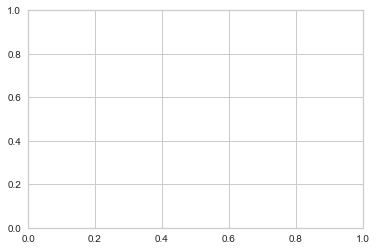

In [218]:
visualizer = IterPlotVisualizer(KMeans(n_clusters=6))
visualizer.transform_fit(X, y, label_col='some_column', label_value="value_one")

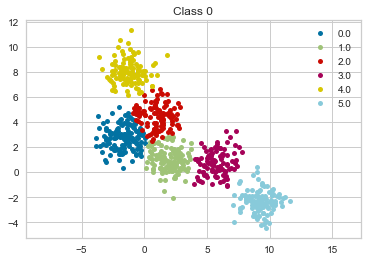

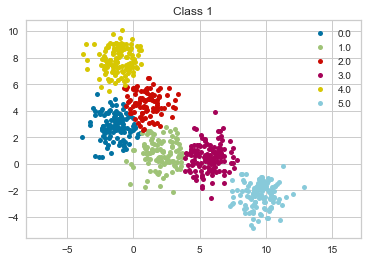

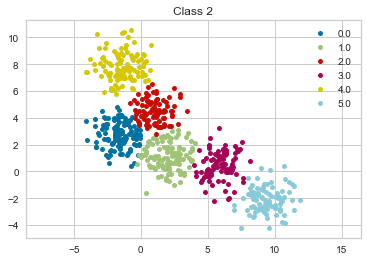

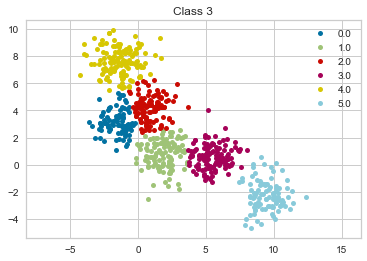

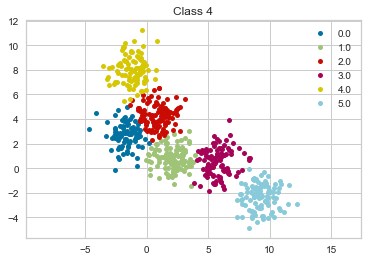

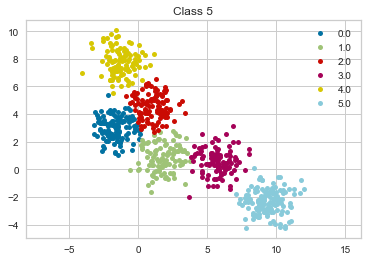

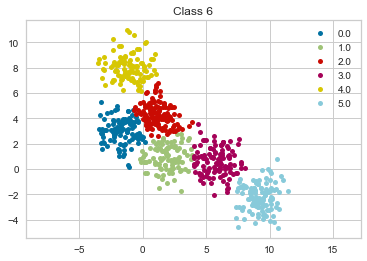

In [233]:
labels_unique = np.unique(visualizer.labels_)

for slice_name, time_slice in enumerate([visualizer.time_slices[n] for n in [0,1,2,4,5,6,7]]):
    slice_name = str(slice_name)
    x_slice = visualizer.X[time_slice]
    labels_slice = visualizer.labels_[time_slice]

    fig, ax = plt.subplots()
    
    for label in labels_unique:
        points_indices = np.where(label==labels_slice)
        point_values = x_slice[points_indices]
        ax.plot(point_values[:,0], point_values[:,1], marker='o', linestyle='', ms=5, label=label)
 
    ax.set_aspect('equal', 'datalim')
    ax.legend()
    plt.grid(True)
    plt.title("Class {label}".format(label=slice_name[0]))
    plt.show()
